<a href="https://colab.research.google.com/github/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/blob/master/cnngan_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a CNNGAN with pytroch

## 1. Import and Preprocessing
### a) Importing modules

In [1]:
# Load required packages - data handling & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load required packages - deep learning 
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
print(f"tensorflow: {torch.__version__}")
import sys
print(f"python: {sys.version[:5]}")

tensorflow: 1.8.1+cu101
python: 3.7.1


### b) Importing the data

In [3]:
#download and save to file
#urllib.request.urlretrieve(
#    "https://media.githubusercontent.com/media/mmeierer/CNN---TensorFlow-vs-PyTorch/main/fashion-mnist_train.csv",
#    "fashion-mnist_train2.csv")

In [4]:
train_data = pd.read_csv('https://media.githubusercontent.com/media/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/master/fashion-mnist_train.csv')

In [5]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [6]:
train_images = train_data.iloc[:,1:]

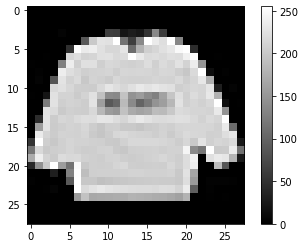

In [7]:
plt.figure()
plt.imshow(train_images.values[0].reshape(28,28), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c) Data preparation

In [8]:
# use maximum normalization
train_images = train_images / np.float32(255)

In [9]:
train_images.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,0.000000,0.411765,0.360784,0.396078,0.419608,0.392157,0.517647,0.000000,0.000000,0.007843,0.015686,0.0,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.588235,0.890196,...,0.827451,0.862745,0.839216,0.290196,0.000000,1.000000,0.870588,0.501961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172549,0.047059,0.0,0.0,0.156863,0.525490,0.635294,0.749020,0.839216,0.639216,0.572549,0.647059,0.309804,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,0.447059,0.717647,0.439216,0.215686,0.090196,0.282353,0.400000,0.647059,0.627451,0.109804,0.000000,0.0,0.000000,0.003922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.094118,0.737255,0.639216,0.364706,0.533333,...,0.670588,0.976471,0.811765,0.772549,0.792157,0.176471,0.000000,0.011765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.003922,0.0,0.0,0.000000,0.086275,0.082353,0.098039,0.270588,0.203922,0.176471,0.290196,0.152941,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.180392,0.000000,0.082353,0.266667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.098039,0.733333,0.741176,0.000000,...,0.901961,0.929412,0.898039,0.000000,0.000000,0.003922,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.266667,0.454902,0.439216,0.533333,0.576471,0.564706,0.474510,0.400000,0.247059,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0



## 2. Model specific data preparation (tensorflow)
## a) Load the data

In [10]:
x_train_pt = torch.from_numpy(train_images.values.reshape((-1, 1, 28, 28)))

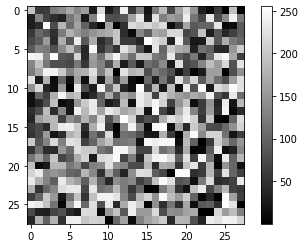

In [11]:
# use random seed to create fake input data
seed = torch.rand((28,28))
seed_im = seed.numpy() * 255
plt.figure()
plt.imshow(seed_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### b) Tensor view of the data

In [12]:
x_train_pt.shape

torch.Size([60000, 1, 28, 28])

In [13]:
seed.shape

torch.Size([28, 28])

In [14]:
x_train_pt[0][0][5]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1843, 0.9882, 0.9176, 0.9333,
        0.8784, 0.8431, 0.8431, 0.8980, 0.4235, 0.7059, 0.8118, 0.8392, 0.8784,
        0.9059, 0.9765, 0.9961, 0.1765, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

## 3. Model definition

In [15]:
def weights_init(m):
  if isinstance(m, nn.Linear):
      nn.init.uniform_(m.weight.data, -1,1)
      nn.init.zeros_(m.bias.data)
  if isinstance(m, nn.Conv2d):
      nn.init.zeros_(m.bias.data)
  if isinstance(m, nn.ConvTranspose2d):
      nn.init.zeros_(m.bias.data)

In [16]:
class Reshape(nn.Module):
    def __init__(self, channels, height, width):
        super(Reshape, self).__init__()
        self.shape = (channels, height, width)

    def forward(self, x):
        return x.view(self.shape)

### a.1) Generator

In [17]:
def generator_model():
    model = nn.Sequential()
    model.add_module("Conv2D1", nn.ConvTranspose2d(100, 64, 7, stride=1, padding=0, bias=True))
    #model.add_module("Reshape", Reshape(64, 7, 7))
    model.add_module("Batchnorm1", nn.BatchNorm2d(64))
    model.add_module("LeakyRelu1", nn.LeakyReLU())
    
    model.add_module("Conv2D2", nn.ConvTranspose2d(64, 32, (8,8), stride=(1,1), padding=0, bias=True))
    model.add_module("Batchnorm2", nn.BatchNorm2d(32))
    model.add_module("LeakyRelu2", nn.LeakyReLU())
    
    model.add_module("Conv2D3", nn.ConvTranspose2d(32, 1, (15,15), stride=1, padding=0, bias=True))
    model.add_module("Batchnorm3", nn.BatchNorm2d(1))
    model.add_module("Sigmoid1", nn.Sigmoid())
    return model
generator = generator_model()
#generator.eval()

In [18]:
# generated image not trained
fake_im_not_trained = generator(torch.rand([1, 100, 1, 1]))
# check output shape of generator
fake_im_not_trained.shape

torch.Size([1, 1, 28, 28])

###  a.2) Inspect the generator model

In [19]:
print(generator)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (Batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Conv2D2): ConvTranspose2d(64, 32, kernel_size=(8, 8), stride=(1, 1))
  (Batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): ConvTranspose2d(32, 1, kernel_size=(15, 15), stride=(1, 1))
  (Batchnorm3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Sigmoid1): Sigmoid()
)


In [20]:
generator.apply(weights_init)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (Batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Conv2D2): ConvTranspose2d(64, 32, kernel_size=(8, 8), stride=(1, 1))
  (Batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): ConvTranspose2d(32, 1, kernel_size=(15, 15), stride=(1, 1))
  (Batchnorm3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Sigmoid1): Sigmoid()
)

### a.3) Inspect the first convolutional layer

In [21]:
generator[0].weight[0]

tensor([[[-3.8887e-03,  3.0843e-03, -1.5766e-02,  ..., -1.5429e-02,
           2.2041e-05, -1.2728e-02],
         [-1.3659e-02, -1.0908e-02,  1.0692e-02,  ..., -1.5092e-03,
          -1.2230e-02, -1.6438e-02],
         [ 6.6543e-03,  1.1022e-03,  1.0358e-02,  ...,  4.9830e-03,
           1.5067e-02, -1.4729e-02],
         ...,
         [-9.3979e-03, -1.7596e-02,  3.7607e-03,  ..., -5.5988e-03,
          -4.7987e-03,  1.4807e-02],
         [-1.5566e-02, -7.0398e-03,  1.0977e-02,  ...,  5.0354e-03,
          -1.7141e-03,  1.2319e-02],
         [-1.5168e-02, -7.2223e-03, -1.5436e-02,  ..., -2.8202e-03,
          -1.5201e-03,  1.5687e-02]],

        [[ 1.3100e-02, -5.0210e-03, -9.6128e-03,  ...,  4.6047e-03,
          -2.4638e-03, -1.6006e-02],
         [-1.5325e-02, -1.1302e-02,  6.3962e-03,  ...,  4.4586e-03,
           9.3401e-03,  4.7226e-04],
         [-1.5836e-03, -1.6454e-02,  1.3041e-02,  ...,  1.0478e-02,
          -1.2306e-02, -5.1995e-03],
         ...,
         [-9.0524e-03, -9

In [22]:
generator[0].weight.shape

torch.Size([100, 64, 7, 7])

In [23]:
generator[0].bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [24]:
generator[0].bias.shape

torch.Size([64])

### b.1) Discriminator

In [25]:
def discriminator_model():
    model = nn.Sequential()
    model.add_module("Conv2D1", nn.Conv2d(1, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("Pooling1", nn.AvgPool2d(kernel_size=2, stride=2))
    model.add_module("LeakyRelu1", nn.LeakyReLU())
    model.add_module("Dropout1", nn.Dropout(0.3))
    
    model.add_module("Conv2D2", nn.Conv2d(2, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("LeakyRelu2", nn.LeakyReLU())
    
    model.add_module("Conv2D3", nn.Conv2d(2, 1, kernel_size=5, stride=1, padding=0))
    model.add_module("LeakyRelu3", nn.LeakyReLU())
    
    model.add_module("Flatten1", nn.Flatten())
    
    model.add_module("Dense1", nn.Linear(100,100))
    model.add_module("LeakyRelu4", nn.LeakyReLU())
    
    model.add_module("Dense2", nn.Linear(100,64))
    model.add_module("Tanh", nn.Tanh())
    
    model.add_module("Dense3", nn.Linear(64,1))
    model.add_module("Sigmoid", nn.Sigmoid())
    return model
discriminator = discriminator_model()
#discriminator = discriminator.float()

### b.2) Inspect the discriminator model

In [26]:
print(discriminator)
discriminator(fake_im_not_trained)

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1))
  (LeakyRelu3): LeakyReLU(negative_slope=0.01)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=100, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.01)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)


tensor([[0.5103]], grad_fn=<SigmoidBackward>)

In [27]:
discriminator.apply(weights_init)

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1))
  (LeakyRelu3): LeakyReLU(negative_slope=0.01)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=100, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.01)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)

### b.3) Inspect the first convolutional layer

In [28]:
discriminator[0].weight[0].type()

'torch.FloatTensor'

In [29]:
discriminator[0].weight.shape

torch.Size([2, 1, 5, 5])

In [30]:
discriminator[0].bias

Parameter containing:
tensor([0., 0.], requires_grad=True)

In [31]:
discriminator[0].bias.shape

torch.Size([2])

## 4. Loss & Optimizer

### 4.a) Generator loss

In [32]:
cross_entropy = nn.BCEWithLogitsLoss()
def generator_loss(fake_output):
    return cross_entropy(torch.ones_like(fake_output), fake_output)

### 4.b) Discriminator loss

In [33]:
def real_discriminator_loss(real_output):
    return  cross_entropy(torch.ones_like(real_output), real_output)

def fake_discriminator_loss(fake_output):
    return cross_entropy(torch.zeros_like(fake_output), fake_output)

SyntaxError: ignored

## 4.c) Optimizers

In [ ]:
generator_optimizer = optim.Adam(generator.parameters(), lr=1e-3)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)

#train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy') # only for discriminator

def correct_classification(y_true, y_prob):
    assert y_true.size() == y_prob.size()
    y_prob = (y_prob > 0.5).float()
    return (y_true == y_prob).sum().item()

## 5. Training

In [ ]:
# This annotation causes the function to be "compiled".
#@tf.function
def train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size = 100):
    gen_loss_tot = []
    disc_loss_tot = []
    disc_acc_real_tot = 0
    disc_acc_fake_tot = 0
    generator.train()
    discriminator.train()
    for beg_i in range(0, x_train_pt.shape[0], batch_size):
        x_train_batch_pt = x_train_pt[beg_i:beg_i + batch_size]

        x_fake_batch_pt = torch.rand([batch_size, 100, 1, 1])
        
        discriminator_optimizer.zero_grad()
        real_output = discriminator(x_train_batch_pt.float()).view(-1)
        disc_loss_real = real_discriminator_loss(real_output)
        disc_loss_real.backward()
        
        generated_images = generator(x_fake_batch_pt)
        fake_output = discriminator(generated_images.detach()).view(-1)
        disc_loss_fake = fake_discriminator_loss(fake_output)
        disc_loss_fake.backward()
        err = disc_loss_fake + disc_loss_real
        discriminator_optimizer.zero_grad()
        
        # optimize generator
        generator_optimizer.zero_grad()
        fake_output = discriminator(generated_images.detach()).view(-1)
        gen_loss = generator_loss(fake_output)
        gen_loss.backward()
        generator_optimizer.step()
        
        gen_loss_tot.append(gen_loss.mean().item())
        disc_loss_tot.append(err.mean().item())
        disc_acc_real_tot += correct_classification(torch.ones_like(real_output), real_output)
        disc_acc_fake_tot += correct_classification(torch.zeros_like(fake_output), fake_output)

    disc_acc_real_tot = disc_acc_real_tot/x_train_pt.size(0)
    disc_acc_fake_tot = disc_acc_fake_tot/x_train_pt.size(0)
    disc_acc_tot = np.mean([disc_acc_real_tot, disc_acc_fake_tot])
    return gen_loss_tot, disc_loss_tot, disc_acc_tot

In [ ]:
train_losses_generator_pt = []
train_losses_discriminator_pt = []
train_acc_discriminator_pt = []
epochs = 15

for epoch in range(epochs):
    gen_loss, disc_loss, disc_acc = train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer)
    gen_loss = np.mean(gen_loss)
    disc_loss = np.mean(disc_loss)
    train_losses_generator_pt.append(gen_loss)
    train_losses_discriminator_pt.append(disc_loss)
    train_acc_discriminator_pt.append(disc_acc*100)


    template = ("Epoch {}, Loss_Generator: {}, Loss_Discriminator: {}, Discriminator_Accuracy: {}")
    print(template.format(epoch+1, gen_loss, disc_loss, disc_acc*100))

### b) Training progress

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_acc_discriminator_pt)
plt.title('discriminator accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['discriminator_train'], loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_losses_generator_pt)
plt.plot(train_losses_discriminator_pt)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper right')
plt.show()

### c1) Generator output before training

In [ ]:
fake_im_not_trained = fake_im_not_trained.detach().numpy() * 255
fake_im_not_trained = fake_im_not_trained.reshape((28,28))
plt.figure()
plt.imshow(fake_im_not_trained, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c2) Generator output after training

In [ ]:
seed2 = torch.rand([1, 100, 1, 1])
generator.train(False)
fake_im = generator(seed2)
fake_im = fake_im.detach().numpy() * 255
fake_im = fake_im.reshape((28,28))
plt.figure()
plt.imshow(fake_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()